In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
siguniang = pd.read_csv('Mt_Siguniang_2018-2020.csv', index_col='Date', parse_dates = ['Date'])
siguniang = siguniang.fillna(method="ffill")
siguniang.head()

,Tourist_Arrival_volume
Date,
2018-01-01,1074.0
2018-01-02,294.0
2018-01-03,196.0
2018-01-04,174.0
2018-01-05,192.0


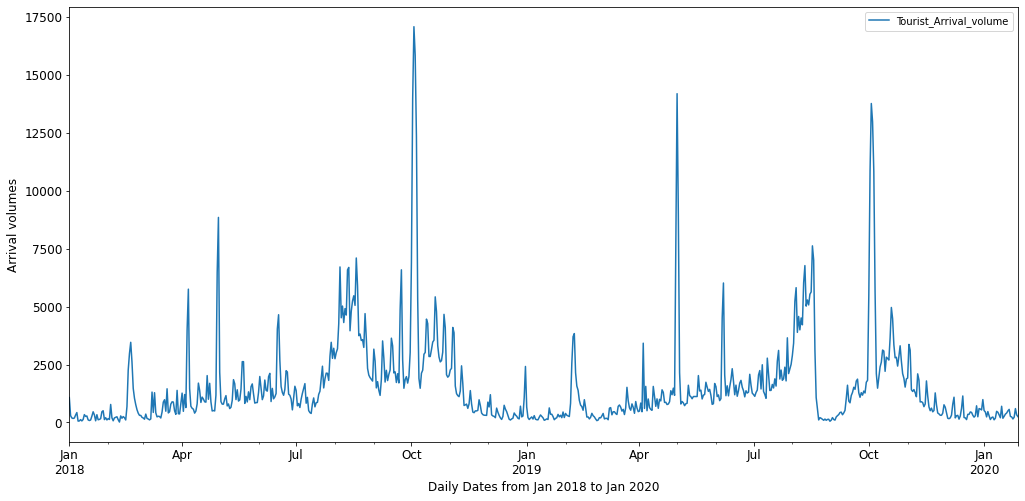

In [3]:
siguniang.plot(y='Tourist_Arrival_volume', subplots=True, figsize=(17,8), fontsize=12)
plt.xlabel('Daily Dates from Jan 2018 to Jan 2020',fontsize=12)
plt.ylabel('Arrival volumes',fontsize=12)
plt.show()

In [4]:
train_start_dt = '2018-01-01'
test_start_dt = '2019-09-15'

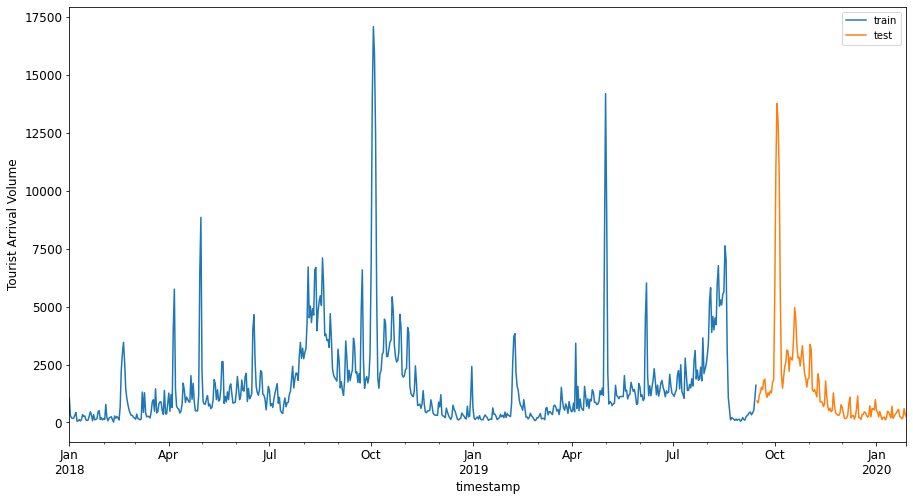

In [5]:
siguniang[(siguniang.index < test_start_dt) & (siguniang.index >= train_start_dt)][['Tourist_Arrival_volume']].rename(columns={'Tourist_Arrival_volume':'train'}) \
    .join(siguniang[test_start_dt:][['Tourist_Arrival_volume']].rename(columns={'Tourist_Arrival_volume':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Tourist Arrival Volume', fontsize=12)
plt.show()

In [6]:
train = siguniang.copy()[(siguniang.index >= train_start_dt) & (siguniang.index < test_start_dt)][['Tourist_Arrival_volume']]
test = siguniang.copy()[siguniang.index >= test_start_dt][['Tourist_Arrival_volume']]

print('Shape of the training data: ', train.shape)
print('Shape of the test data: ', test.shape)

Shape of the training data:  (622, 1)
Shape of the test data:  (136, 1)


In [7]:
scaler = MinMaxScaler()
train['Tourist_Arrival_volume'] = scaler.fit_transform(train)

In [8]:
test['Tourist_Arrival_volume'] = scaler.transform(test)

In [9]:
train_data = train.values
test_data = test.values

In [10]:
timesteps=3

In [11]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(620, 3)

In [12]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(134, 3)

In [13]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(620, 2) (620, 1)
(134, 2) (134, 1)


In [14]:
model = SVR(kernel='linear', gamma=0.5, C=35, epsilon=0.05)

In [15]:
model.fit(x_train, y_train[:,0])

SVR(C=35, epsilon=0.05, gamma=0.5, kernel='linear')

In [16]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(620, 1) (134, 1)


In [17]:
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

620 134


In [18]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

620 134


In [19]:
train_timestamps = siguniang[(siguniang.index < test_start_dt) & (siguniang.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = siguniang[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

620 134


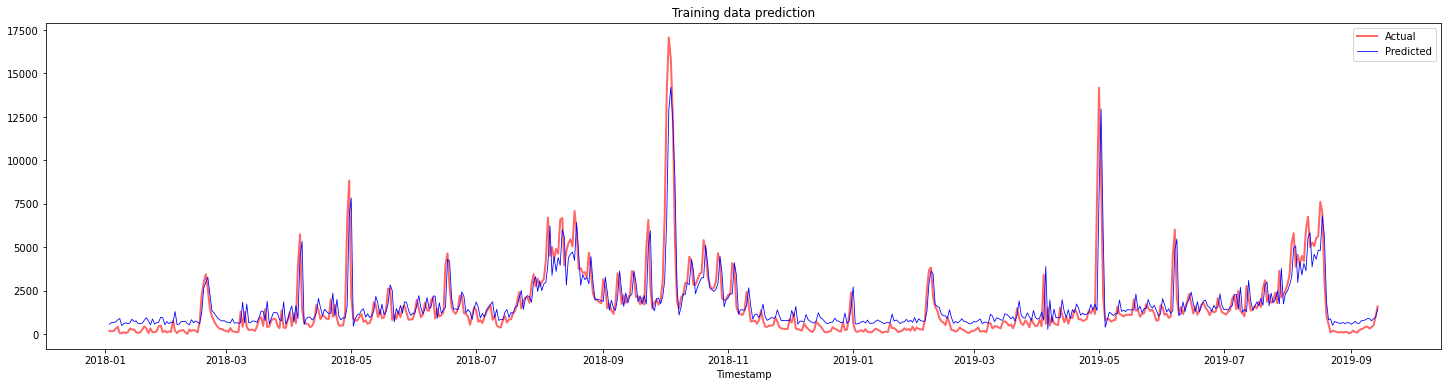

In [20]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [21]:
print('MAPE for training data: ', mean_absolute_percentage_error(y_train_pred, y_train))

MAPE for training data:  0.4440181497556506


In [22]:
print('RMSE for training data: ', math.sqrt(mean_squared_error(y_train_pred, y_train)))

RMSE for training data:  1016.9161769156613


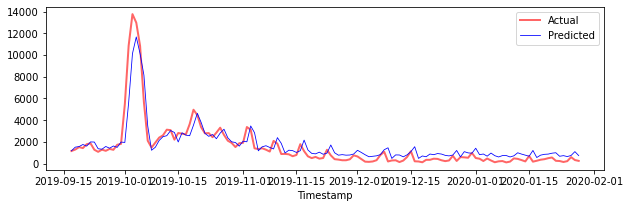

In [23]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [24]:
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test_pred, y_test))

MAPE for testing data:  0.3980312358608456


In [25]:
print('RMSE for testing data: ',math.sqrt(mean_squared_error(y_test_pred, y_test)))

RMSE for testing data:  863.1931277944626


In [26]:
data = siguniang.copy().values

data = scaler.transform(data)

data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (756, 3)
X shape:  (756, 2) 
Y shape:  (756, 1)


In [27]:
Y_pred = model.predict(X).reshape(-1,1)

Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

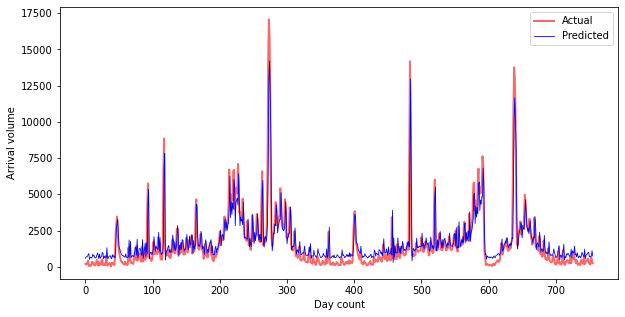

In [28]:
plt.figure(figsize=(10,5))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Day count')
plt.ylabel('Arrival volume')
plt.show()

In [29]:
print('MAPE for SVR on Mt.Siguniang: ', mean_absolute_percentage_error(Y_pred, Y))

MAPE for SVR on Mt.Siguniang:  0.4356589723629663


In [30]:
print('RMSE for SVR on Mt.Siguniang: ', math.sqrt(mean_squared_error(Y_pred, Y)))

RMSE for SVR on Mt.Siguniang:  990.7228195387692


# Prediction

In [33]:
yhat = model.predict([[31, 42]])
act = 43
print('Predicted value for April 24th: ', int(yhat[0]))
print('Actual Number of tourists on April 24th: ', act )
print("MAPE for April 24th: %.2f" % (abs(act - yhat[0])/act))

Predicted value for April 24th:  34
Actual Number of tourists on April 24th:  43
MAPE for April 24th: 0.20
